In [ ]:
# Instalasi Mesa jika belum terinstal
# Install the Mesa package if you don't have it installed
!pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 473.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import random
from google.colab import files

class Vehicle(Agent):
    """ An agent representing a vehicle with basic properties and metrics collection. """
    def __init__(self, unique_id, model, speed, lane, entry_time, safe_distance=5, follow_distance=10):
        super().__init__(unique_id, model)
        self.speed = speed
        self.lane = lane
        self.entry_time = entry_time
        self.intent_to_change_lane = False
        self.has_exited = False
        self.safe_distance = safe_distance
        self.follow_distance = follow_distance

    def step(self):
        if not self.has_exited:
            self.check_intent_to_change_lane()
            self.move()

    def check_intent_to_change_lane(self):
        adjacent_lane = self.lane + 1 if self.lane < self.model.grid.width - 1 else self.lane - 1
        avg_speed_adjacent_lane = np.mean([a.speed for a in self.model.grid.get_cell_list_contents([(self.pos[0], adjacent_lane)])])

        if avg_speed_adjacent_lane > self.speed + 2:  # Check if average speed in adjacent lane is higher
            self.intent_to_change_lane = True

    def move(self):
        if not self.has_exited:
            new_y = min(self.pos[1] + self.speed, self.model.grid.height - 1)
            new_position = (self.pos[0], new_y)

            if self.model.grid.is_cell_empty(new_position):
                self.model.grid.move_agent(self, new_position)
            else:
                self.model.crash_count += 1

            if new_y == self.model.grid.height - 1:
                self.has_exited = True
                travel_time = self.model.schedule.time - self.entry_time
                self.model.total_travel_time += travel_time

class TrafficLight:
    """Class to manage the traffic light changes."""
    def __init__(self):
        self.state = "green"  # Can be 'green', 'yellow', 'red'
        self.green_duration = 45
        self.yellow_duration = 5
        self.red_duration = 30
        self.timer = 0

    def step(self):
        self.timer += 1
        if self.state == "green" and self.timer > self.green_duration:
            self.state = "yellow"
            self.timer = 0
        elif self.state == "yellow" and self.timer > self.yellow_duration:
            self.state = "red"
            self.timer = 0
        elif self.state == "red" and self.timer > self.red_duration:
            self.state = "green"
            self.timer = 0

class IntersectionVehicle(Agent):
    """An agent representing a vehicle with dynamic behavior at intersections."""
    def __init__(self, unique_id, model, speed, direction):
        super().__init__(unique_id, model)
        self.speed = speed
        self.direction = direction
        self.intent = np.random.choice(["straight", "left", "right"], p=[0.5, 0.25, 0.25])

    def step(self):
        if self.pos == self.model.intersection_center:
            if self.check_traffic_light_and_direction():
                if self.intent == "straight" and self.is_clear_straight():
                    self.go_straight()
                elif self.intent == "left" and self.is_clear_left():
                    self.turn_left()
                elif self.intent == "right" and self.is_clear_right():
                    self.turn_right()
            # Vehicle waits if it's not safe to move
        else:
            self.default_move()  # Normal movement when not at the intersection

    def check_traffic_light_and_direction(self):
        traffic_light = self.model.traffic_light
        if (traffic_light.state == "green" and self.direction in ["north", "south"]) or \
           (traffic_light.state == "red" and self.direction in ["east", "west"]):
            return True
        return False

    def is_clear_straight(self):
        # Check the next cell in the direction of travel
        next_pos = (self.pos[0], self.pos[1] + self.speed) if self.direction in ['north', 'south'] else (self.pos[0] + self.speed, self.pos[1])
        return self.model.grid.is_cell_empty(next_pos)

    def is_clear_left(self):
        # Check the next cell to the left based on current direction
        if self.direction == 'north':
            next_pos = (self.pos[0] - 1, self.pos[1])
        elif self.direction == 'east':
            next_pos = (self.pos[0], self.pos[1] + 1)
        elif self.direction == 'south':
            next_pos = (self.pos[0] + 1, self.pos[1])
        else:  # west
            next_pos = (self.pos[0], self.pos[1] - 1)
        return self.model.grid.is_cell_empty(next_pos)

    def is_clear_right(self):
        # Check the next cell to the right based on current direction
        if self.direction == 'north':
            next_pos = (self.pos[0] + 1, self.pos[1])
        elif self.direction == 'east':
            next_pos = (self.pos[0], self.pos[1] - 1)
        elif self.direction == 'south':
            next_pos = (self.pos[0] - 1, self.pos[1])
        else:  # west
            next_pos = (self.pos[0], self.pos[1] + 1)
        return self.model.grid.is_cell_empty(next_pos)

    def go_straight(self):
        # Calculate the next position
        if self.direction in ['north', 'south']:
            next_y = self.pos[1] + (self.speed if self.direction == 'north' else -self.speed)
            next_pos = (self.pos[0], next_y)
        else:
            next_x = self.pos[0] + (self.speed if self.direction == 'east' else -self.speed)
            next_pos = (next_x, self.pos[1])

        # Check if the position is within grid bounds
        if 0 <= next_pos[0] < self.model.grid.width and 0 <= next_pos[1] < self.model.grid.height:
            if self.model.grid.is_cell_empty(next_pos):
                self.model.grid.move_agent(self, next_pos)

    def turn_left(self):
        # Determine the next position based on current direction
        if self.direction == 'north':
            next_pos = (self.pos[0] - 1, self.pos[1])
        elif self.direction == 'east':
            next_pos = (self.pos[0], self.pos[1] + 1)
        elif self.direction == 'south':
            next_pos = (self.pos[0] + 1, self.pos[1])
        elif self.direction == 'west':
            next_pos = (self.pos[0], self.pos[1] - 1)

        # Check if the position is within grid bounds and move the agent
        if 0 <= next_pos[0] < self.model.grid.width and 0 <= next_pos[1] < self.model.grid.height:
            if self.model.grid.is_cell_empty(next_pos):
                self.model.grid.move_agent(self, next_pos)

    def turn_right(self):
        # Determine the next position based on current direction
        if self.direction == 'north':
            next_pos = (self.pos[0] + 1, self.pos[1])
        elif self.direction == 'east':
            next_pos = (self.pos[0], self.pos[1] - 1)
        elif self.direction == 'south':
            next_pos = (self.pos[0] - 1, self.pos[1])
        elif self.direction == 'west':
            next_pos = (self.pos[0], self.pos[1] + 1)

        # Check if the position is within grid bounds and move the agent
        if 0 <= next_pos[0] < self.model.grid.width and 0 <= next_pos[1] < self.model.grid.height:
            if self.model.grid.is_cell_empty(next_pos):
                self.model.grid.move_agent(self, next_pos)

    def default_move(self):
        # Default move function, assumes movement straight along the direction
        self.go_straight()

class TrafficModel(Model):
    """A model with some number of vehicles, including performance metrics."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, False)  # False for non-toroidal grid
        self.schedule = RandomActivation(self)
        self.crash_count = 0
        self.total_travel_time = 0
        self.exited_vehicles = 0

        # Traffic light and intersection
        self.traffic_light = TrafficLight()
        self.intersection_center = (width // 2, height // 2)

        # Data collector
        self.data_collector = DataCollector(
            {"Average Travel Time": lambda m: m.calculate_avg_travel_time(),
             "Throughput": lambda m: m.exited_vehicles,
             "Crash Count": "crash_count"})

        # Create vehicles
        for i in range(self.num_agents):
            speed = random.randint(10, 20)  # Random speed between 10 m/s and 20 m/s
            lane = random.randint(1, 2)  # Random lane assignment
            vehicle = Vehicle(i, self, speed, lane, self.schedule.time)
            self.schedule.add(vehicle)
            x = random.randrange(self.grid.width)
            y = 0  # All vehicles start at y=0
            self.grid.place_agent(vehicle, (x, y))

    def calculate_avg_travel_time(self):
        if self.exited_vehicles > 0:
            return self.total_travel_time / self.exited_vehicles
        else:
            return 0

    def step(self):
        '''Advance the model by one step and collect data.'''
        self.schedule.step()
        self.traffic_light.step()
        self.data_collector.collect(self)
        # Update the exited vehicles count after each step
        self.exited_vehicles += sum(1 for agent in self.schedule.agents if agent.has_exited)

def run_simulation():
    # Parameters
    num_vehicles = 10
    width, height = 20, 20  # Dimensions of the grid

    # Create and run the model
    model = TrafficModel(num_vehicles, width, height)
    for i in range(180):  # Simulate for 180 seconds
        model.step()

    # Get collected data
    results = model.data_collector.get_model_vars_dataframe()

    return results

# Running the simulation
results_df = run_simulation()
print(results_df)

# Save the DataFrame to a CSV file
results_df.to_csv('results.csv', index=False)

# Download the CSV file
files.download('results.csv')


     Average Travel Time  Throughput  Crash Count
0               0.000000           0            0
1               4.000000           2            4
2               0.666667          12            4
3               0.363636          22            4
4               0.250000          32            4
..                   ...         ...          ...
175             0.004592        1742            4
176             0.004566        1752            4
177             0.004540        1762            4
178             0.004515        1772            4
179             0.004489        1782            4

[180 rows x 3 columns]


<ipython-input-3-5efd1d3b1e1e>:12: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

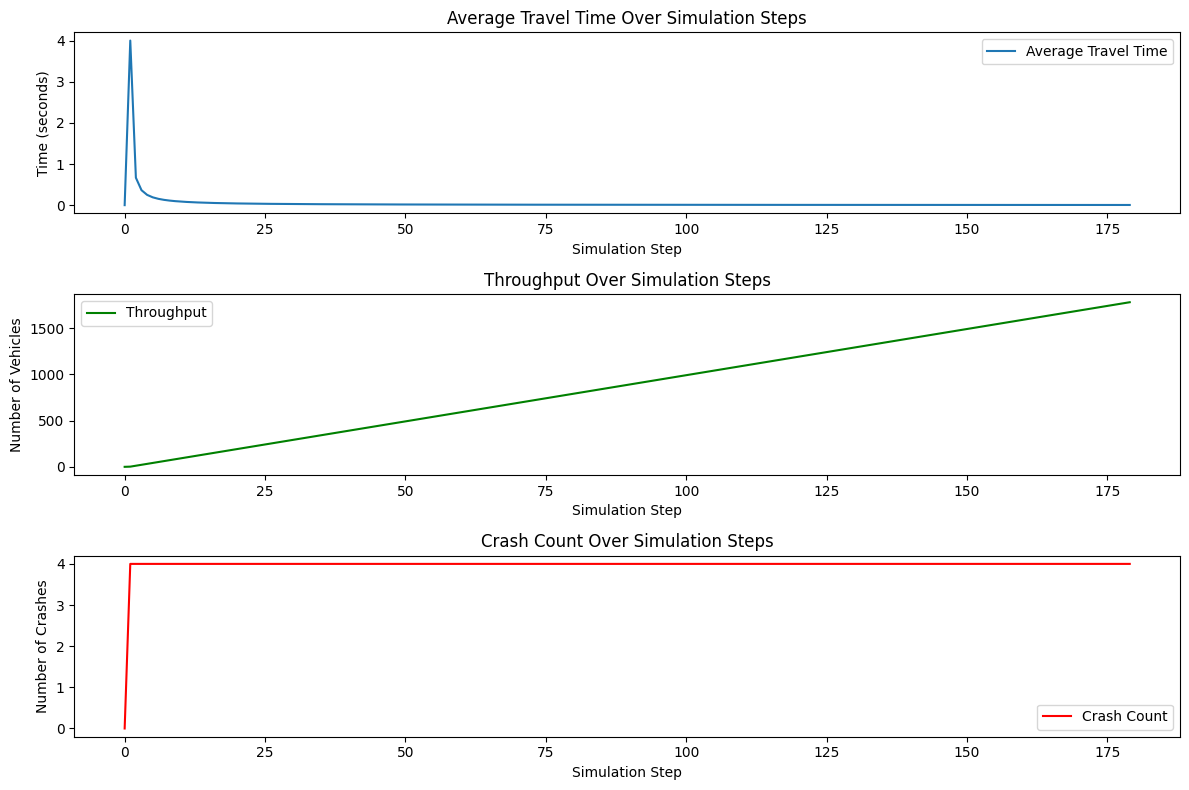

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
def visualize_results(results_df):
    plt.figure(figsize=(12, 8))

    # Plot for Average Travel Time
    plt.subplot(311)
    plt.plot(results_df['Average Travel Time'], label='Average Travel Time')
    plt.xlabel('Simulation Step')
    plt.ylabel('Time (seconds)')
    plt.title('Average Travel Time Over Simulation Steps')
    plt.legend()

    # Plot for Throughput
    plt.subplot(312)
    plt.plot(results_df['Throughput'], label='Throughput', color='green')
    plt.xlabel('Simulation Step')
    plt.ylabel('Number of Vehicles')
    plt.title('Throughput Over Simulation Steps')
    plt.legend()

    # Plot for Crash Count
    plt.subplot(313)
    plt.plot(results_df['Crash Count'], label='Crash Count', color='red')
    plt.xlabel('Simulation Step')
    plt.ylabel('Number of Crashes')
    plt.title('Crash Count Over Simulation Steps')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizing the data
visualize_results(results_df)